# Packages

In [28]:
using ITensors, Integrals, BenchmarkTools, Plots, QuantumOptics, LinearAlgebra, Interpolations, DifferentialEquations, Metal

In [29]:
using JlD2

ArgumentError: ArgumentError: Package JlD2 not found in current path.
- Run `import Pkg; Pkg.add("JlD2")` to install the JlD2 package.

# To Do 


- Add comments explaining stuff
- combine swap and beamsplitter into one function
- Maybe not destroy the original MPO when taking a projection ✅
- Finally actually check if we are getting the excpected state (bell state of sorts)✅(we are)
- write out measuring the stabalisers
- think about how to add noise cavities


When with a simple just beamsplitter case, the partial trace multiplies in the probability of the projection into the density matrix
<br/> (Confirming what we already knew)

#Doubt if opsum works for diff dimensions for atom and cavities

# Functions

## State Definition

In [2]:
function ITensors.op(::OpName"Ground" , ::SiteType"Qudit" , d::Int)
    mat = zeros(d, d)
    mat[1,1] = 1
    return mat
end
function ITensors.op(::OpName"Ground" , ::SiteType"Qubit" )
    mat = zeros(2, 2)
    mat[1,1] = 1
    return mat
end

In [3]:
function ITensors.op(::OpName"Excite1" , ::SiteType"Qudit" , d::Int)
    mat = zeros(d, d)
    mat[2,2] = 1
    return mat
end
function ITensors.op(::OpName"Excite1" , ::SiteType"Qubit")
    mat = zeros(2, 2)
    mat[2,2] = 1
    return mat
end

In [4]:
function ITensors.op(::OpName"Sz" , ::SiteType"Qudit" , d::Int)
    mat = zeros(d, d)
    mat[1,1] = 1
    mat[2,2] = -1
    return mat
end

## Operations on the MPO (Beamsplitter/Swap/Copy)

In [5]:
#can try beamsplitter with opsum, but dont make the huge larger Itensor then mult in, is harder, makes a ITensor of 14+ indices that is erronous


In [1]:
function beamsplitter_cunstruc(no_cavs, double_sites)
    Iden = MPO(double_sites, "I")
    beamsplitter = Iden
    for i=1:no_cavs
        op = ((op("A",double_sites[i]) * op("Adag",double_sites[i+no_cavs])) + (op("A",double_sites[i+no_cavs]) * op("Adag",double_sites[i])))
        beamsplitter *= exp(-im * 0.25 * pi * op)
    end
    return beamsplitter
end

beamsplitter_cunstruc (generic function with 1 method)

In [6]:


function beamsplitter!(MPO_i, index_1, index_2, site_list)
    cutoff = 1E-15
    
    op_1 = ((op("A",site_list[index_1]) * op("Adag",site_list[index_2])) + (op("A",site_list[index_2]) * op("Adag",site_list[index_1])))
    H_ = exp((-im/4) * pi * op_1)
    # for i=1:length(site_list)
    #     (i==index_1 || i==index_2) ? nothing : H_*= op("I",site_list[i])
    # end
    Iden = MPO(site_list, "I")
    H_ = apply(H_, Iden)
    H2 = apply(H_, MPO_i; cutoff=cutoff)
    #easier to use apply since preserves MPO data type and doesnt change to iTensor type
    #requires iTensor be applied to an MPO in that order particularly hence double dagger
    H3 = apply(H2, H_; cutoff=cutoff)

    MPO_i[:] = H3
    MPO_i /= trace(MPO_i, site_list)

    return nothing
end

beamsplitter! (generic function with 1 method)

In [9]:
function swap!(MPO_i, index_1, index_2, site_list)
    cutoff = 1E-20

    op_1 = ((op("A",site_list[index_1]) * op("Adag",site_list[index_2])) + (op("A",site_list[index_2]) * op("Adag",site_list[index_1])))
    H_ = exp((-im/2) * pi * op_1)

    H2 = apply(H_, MPO_i ; cutoff)
    H3 = conj(swapprime( apply( H_, swapprime(conj(H2), 1,0); cutoff ), 1,0))


    MPO_i[:] = H3
    MPO_i /= trace(MPO_i, site_list)
    return nothing
end

swap! (generic function with 1 method)

In [10]:
function n_copy_mpo(n, mpo_i, sites)
    #Assuming qudit
    l = length(mpo_i)
    new_inds = siteinds("Qudit", n*l, dim=dim(sites[1]))
    I_mpo = MPO(l*n)
    I_op = OpSum()
    for i=1:l
        for j=1:n
            ind = i + (l*(j-1))
            I_mpo[ind] = deepcopy(mpo_i[i])
            replaceind!(I_mpo[ind], sites[i], new_inds[ind])
            replaceind!(I_mpo[ind], sites[i]', new_inds[ind]')
            I_op += "I",ind
        end
    end
    #applying I to change up link indices
    I_op = MPO(I_op, new_inds)
    I_mpo = apply(I_op, I_mpo)
    I_mpo /= tr(I_mpo)
    #normalize!(I_mpo)
    return I_mpo, new_inds
end

n_copy_mpo (generic function with 1 method)

## Calc derevative

For m output cavities
$$H(t) = H_{sys}(t) + \frac{i}{2}~\left[~~\sum_{i=1}^{m}{\left(\sqrt{\gamma}\hat{c}^\dagger + \sum_{j}^{i-1}{g_{v_j}(t)\hat{a}_j^\dagger}\right) g_{v_i}^*(t)\hat{a}_i} - h.c.~~\right]$$
We're taking system Hamiltonian as identity for the time being

In [11]:
#func calc drho/dt
function drho(sites, rho, gv_f, rg; t=0,  deph = 0)
    #drho(sites, rho, t)
    #(H_int * rho) + (rho * H_int) + sum(Ld rho L)
    cutoff = 1E-10
    no_cavs = length(sites) - 1

    H = OpSum()
    H += -2im,"I",1
    L_0 = OpSum()
    L_0 += rg,"A",1

    for i=2:no_cavs+1

        L_0 += gv_f[i-1](t),"A",i
        H += (rg*gv_f[i-1](t)),"Adag",1,"A",i
        H -= (rg*gv_f[i-1](t)),"A",1,"Adag",i

        #L_0 += exp(t/2),"A",i
        #H += (rg*exp(t/2)),"Adag",1,"A",i
        #H -= (rg*exp(t/2)),"A",1,"Adag",i

        for j=2:i-1

            H += (gv_f[j-1](t)*gv_f[i-1](t)),"Adag",j,"A",i
            H -= (gv_f[j-1](t)*gv_f[i-1](t)),"A",j,"Adag",i
        end
    end

    H = MPO(H, sites)
    #H *= im/2
    drho = 0.5*( apply(H, rho; alg="zipup", cutoff=cutoff) - apply(rho, H; alg="zipup", cutoff=cutoff) )

    #L dagger
    L_0 = MPO(L_0, sites)
    L_0d = swapprime(conj(L_0), 1,0)
    LdL = 0.5 * apply(L_0d , L_0; alg="zipup")

    drho += apply(apply(L_0 , rho; alg="zipup", cutoff=cutoff), L_0d; alg="zipup", cutoff=cutoff)
    drho -= apply(LdL, rho; alg="zipup", cutoff=cutoff)
    drho -= apply(rho, LdL; alg="zipup", cutoff=cutoff)

    if deph!= 0 
        #println("Deph")
        L_1 = OpSum()
        L_1 += sqrt(deph),"Sz",1
        L_1 = MPO(L_1, sites)
        drho += apply(apply(L_1 , rho; alg="zipup", cutoff=cutoff), L_1; alg="zipup", cutoff=cutoff)
        drho -= deph*rho
    end

    return drho
end

drho (generic function with 1 method)

In [12]:
#func calc drho/dt
function drho2(sites, rho, gv_f, rg; t=0, deph = 0, cut_off=1E-10, algo="naive")
    #drho(sites, rho, t)
    #(H_int * rho) + (rho * H_int) + sum(Ld rho L)
    
    no_cavs = length(sites) - 1

    H = OpSum()
    H += "I",1
    L_0 = OpSum()
    L_0 += rg,"A",1

    for i=2:no_cavs+1
        L_0 += gv_f[i-1](t),"A",i
        H += (0.5im*rg*gv_f[i-1](t)),"Adag",1,"A",i
        H -= (0.5im*rg*gv_f[i-1](t)),"A",1,"Adag",i

        for j=2:i-1
            H += (0.5im*gv_f[j-1](t)*gv_f[i-1](t)),"Adag",j,"A",i
            H -= (0.5im*gv_f[j-1](t)*gv_f[i-1](t)),"A",j,"Adag",i
        end
    end

    H = MPO(H, sites; cutoff=cut_off)
    H_rho = apply(H, rho; alg=algo, cutoff=cut_off)
    
    drho_ = -1im*(H_rho - swapprime(conj(deepcopy(H_rho)), 1,0))

    #L dagger
    L_0 = MPO(L_0, sites; cutoff=cut_off)
    L_0d = swapprime(conj(deepcopy(L_0)), 1,0)
    LdL = 0.5 * apply(L_0d , L_0; alg=algo, cutoff=cut_off)

    drho_ += apply(apply(L_0 , rho; alg=algo, cutoff=cut_off), L_0d; alg=algo, cutoff=cut_off)
    LdL_rho = apply(LdL, rho; alg=algo, cutoff=cut_off)
    drho_ -= LdL_rho
    drho_ -= swapprime(conj(deepcopy(LdL_rho)), 1,0)

    if deph!= 0
        L_1 = op("Sz",sites[1])
        drho_ += deph*conj(swapprime( apply( L_1, swapprime(conj(apply(L_1, rho; cutoff=cut_off)), 1,0) ; cutoff=cut_off), 1,0))
        drho_ -= deph*rho
    end

    return drho_
end

drho2 (generic function with 1 method)

In [13]:
#func calc drho/dt
function drho3(rho, p, t)
    #drho(sites, rho, t)
    #(H_int * rho) + (rho * H_int) + sum(Ld rho L)
    sites, gv_f, rg, deph = p
    cut_off=1E-10
    algo="naive"
    no_cavs = length(sites) - 1

    H = OpSum()
    H += "I",1
    L_0 = OpSum()
    L_0 += rg,"A",1

    for i=2:no_cavs+1
        L_0 += gv_f[i-1](t),"A",i
        H += (0.5im*rg*gv_f[i-1](t)),"Adag",1,"A",i
        H -= (0.5im*rg*gv_f[i-1](t)),"A",1,"Adag",i

        for j=2:i-1
            H += (0.5im*gv_f[j-1](t)*gv_f[i-1](t)),"Adag",j,"A",i
            H -= (0.5im*gv_f[j-1](t)*gv_f[i-1](t)),"A",j,"Adag",i
        end
    end

    H = MPO(H, sites; cutoff=cut_off)
    H_rho = apply(H, rho; alg=algo, cutoff=cut_off)
    
    drho_ = -1im*(H_rho - swapprime(conj(deepcopy(H_rho)), 1,0))

    #L dagger
    L_0 = MPO(L_0, sites; cutoff=cut_off)
    L_0d = swapprime(conj(deepcopy(L_0)), 1,0)
    LdL = 0.5 * apply(L_0d , L_0; alg=algo, cutoff=cut_off)

    drho_ += apply(apply(L_0 , rho; alg=algo, cutoff=cut_off), L_0d; alg=algo, cutoff=cut_off)
    LdL_rho = apply(LdL, rho; alg=algo, cutoff=cut_off)
    drho_ -= LdL_rho
    drho_ -= swapprime(conj(deepcopy(LdL_rho)), 1,0)

    if deph!= 0
        L_1 = op("Sz",sites[1])
        drho_ += deph*conj(swapprime( apply( L_1, swapprime(conj(apply(L_1, rho; cutoff=cut_off)), 1,0) ; cutoff=cut_off), 1,0))
        drho_ -= deph*rho
    end

    return drho_
end

drho3 (generic function with 1 method)

## Measurements/Expectations

In [14]:
function trace(MPO_i, sites_i)
    tr_ = 1.0
    for i in 1:length(sites_i)
        tr_ *= delta(sites_i[i], sites_i[i]') * MPO_i[i]
    end
    return tr_[1]
end

trace (generic function with 1 method)

In [15]:
function ITensors.expect(MPO_i, sites_i)
    list_exp = []
    for i in 1:length(sites_i)
        append!(list_exp, trace(apply( op("n", sites_i[i]), MPO_i), sites_i))
    end
    return list_exp
end

In [16]:
#measures <a1 a2 rho adag1 adag2> at sites 1 and 2
function measure_corel(mpo_i, sites, site1, site2)
    AA_op = OpSum()
    AA_op += "A",site1,"A",site2
    AA_op = MPO(AA_op, sites)
    AdAd_op = swapprime(conj(AA_op), 1,0)
    val = trace(apply(AA_op, apply(mpo_i, AdAd_op)), sites)
    return val
end 

measure_corel (generic function with 1 method)

In [17]:
#measures <a1 a2 rho adag1 adag2> at sites 1 and 2
function measure_a(mpo_i, sites, site1)
    A_op = OpSum()
    A_op += "A",site1
    A_op = MPO(A_op, sites)
    Ad_op = swapprime(conj(A_op), 1,0)
    val = trace(apply(A_op, apply(mpo_i, Ad_op)), sites)
    return val
end 

measure_a (generic function with 1 method)

In [18]:
function projection(mpo_i, mps_i)

end

projection (generic function with 1 method)

In [19]:
function g_34(mpo_i, sites, no_cavs)
    # measuring G_34 t, tau integrated
    G_34 = 0.0
    denom1 = 0.0
    denom2 = 0.0
    for i=1:no_cavs
        for j=1:no_cavs
            #if v^2 integrates out to 1
            term = measure_corel(mpo_i, sites, i, no_cavs+j)
            #println(ITensors.expect(double, double_sites))
            #println(term)
            G_34 += 0.5 * term
        end
        denom1 += measure_a(mpo_i, sites, i)
        #println(ITensors.expect(mpo_i, sites))
        denom2 += measure_a(mpo_i, sites, no_cavs+i)
    end
    denom =0.5 * denom1 * denom2

    return G_34/denom
end


g_34 (generic function with 1 method)

## Atom to cavity loop 

In [20]:
function create_MPO(no_cavs, depha, gamma, dt, t_final; sites_provided = [;], reverse=false)

    #creating initial state and sites
    sys_sites = siteinds("Qudit", no_cavs+1, dim=3)
    if length(sites_provided)!=0
        sys_sites = sites_provided
    end
    input_list = repeat(["Ground",],no_cavs+1)
    input_list[1] = "Excite1"
    sys = MPO(sys_sites, input_list)

    #Generating G2
    #gamma = 1
    g_f = g2_(gamma, depha, t_final, dt/2, no_cavs)
    
    println("genfunctions")
    
    expect_list = Array{Float64}(undef, Int(t_final/dt + 1), no_cavs+1)
    expect_list *= 0
    # #ldl_list = [;]
    j = 1
    
    """
    #evolving atom-cavity system
    for i=0:dt:t_final
        d_rho , ldl = drho(sys_sites, sys, g_f, sqrt(gamma); t=i, deph=depha)
        sys +=  dt * d_rho
        sys /= tr(sys)

        push!(ldl_list, ldl)
        expect_list[j,:] = real(ITensors.expect(sys, sys_sites))
        j += 1
        #println(i)
    end
    """
    #bonddim = [;]

    for i=0:dt:t_final
        d_rho1 = drho2(sys_sites, sys, g_f, sqrt(gamma); t=i, deph=depha)
        sys1 = sys + (d_rho1*dt/2)
        #sys1 /=tr(sys1)
        d_rho2 = drho2(sys_sites, sys1, g_f, sqrt(gamma); t=(i+(dt/2)), deph=depha)
        sys2 = sys + (d_rho2*dt/2)
        #sys2 /=tr(sys2)
        d_rho3  = drho2(sys_sites, sys2, g_f, sqrt(gamma); t=(i+(dt/2)), deph=depha)
        sys3 = sys + (d_rho3*dt)
        #sys3 /=tr(sys3)
        d_rho4  = drho2(sys_sites, sys3, g_f, sqrt(gamma); t=(i+dt), deph=depha)
        sys +=  (dt * (d_rho1 + (2*d_rho2) + (2*d_rho3) + d_rho4)/6)
        sys /= trace(sys, sys_sites)

        #push!(ldl_list, (ldl+2*ldl2+2*ldl3+ldl4)/6)
        #println("max bond dim at time: ", maximum(linkdims(sys)), " ", i)
        # #append!(bonddim, maximum(linkdims(sys)))
        expect_list[j,:] = real(ITensors.expect(sys, sys_sites))
        j += 1
    end
    
    #trace out atom
    copy_sys = MPO(no_cavs)
    copy_sys[1] = sys[1] * delta(sys_sites[1], sys_sites[1]') * sys[2]
    for i=2:no_cavs
        copy_sys[i] = deepcopy(sys[i+1]) 
    end
    copy_sys /= trace(copy_sys, sys_sites[2:end])

    return copy_sys, sys_sites[2:end], expect_list
    #return sys, sys_sites
    #, g_f
    # return expect_list
end

create_MPO (generic function with 1 method)

## G2 function maker

In [22]:
#make a g2 function, outputs the cavity functions

function g2(gamma, deph, t_fin, dt, no_cavs)

    
    basis = SpinBasis(1//2)
    a = sigmam(basis)
    at = sigmap(basis)
    H =  identityoperator(basis)
    J = [sqrt(gamma)*a, sqrt(deph)*sigmaz(basis)]

    t_list = [0:dt:t_fin;]
    t_size = length(t_list)
    corel_m = Array{ComplexF64}(undef, t_size, t_size)
    corel_m *= 0
    
    ρ₀ = spinup(basis) ⊗ dagger(spinup(basis))
    
    tout, ρt_master = timeevolution.master(t_list, ρ₀, H, J; dt=dt)
    for i=1:t_size-1
        rhot = ρt_master[i]
        corel_m[i,i:end] = timecorrelations.correlation(t_list[1:(t_size-i+1)], rhot, H, J, at, a)
    end
    corel_m[t_size,t_size] = 0.0
    corel_m = -diagm((diag(corel_m))) + corel_m + conj(corel_m)'
    corel_m = real(corel_m)
    eigenvals, eigens = eigen(corel_m; sortby=-)
    
    # eigens2 = deepcopy(eigens)
    # for i=1:Int(no_cavs)
    #     eigens2[:,no_cavs-i+1] = deepcopy(eigens[:,i])
    # end
    # eigens = eigens2
    
    gv = Dict()
    alpha = Dict()
    gv_f = [;]
    for i=1:Int(no_cavs)
        for j=1:Int(i-1)
            alpha[[i,j]] = [0.0,]
            for t=1:Int(t_size-1)
                at_ = -(gv[j][t]*eigens[t,i]*dt)
                for k=1:Int(j-1)
                    at_ -= gv[j][t]*gv[k][t]*alpha[[i,k]][t]*dt
                end
                at_ += (1-(dt*0.5*(gv[j][t])^2))*(alpha[[i,j]][end])
                push!(alpha[[i,j]], at_)

            end
        end
        v_ = eigens[:,Int(i)]

        for k=1:Int(i-1)
            v_ += (gv[k].* alpha[[i,k]])
        end
        norm = dt * cumsum(v_.^2)
        #norm[1] = 1E-3
        gv[i] = -v_./sqrt.(norm)
        #i > 1 ? gv[i][1] = 0 : nothing
        extrap = cubic_spline_interpolation(0:dt:t_fin, gv[i]; extrapolation_bc=0)
        push!(gv_f, extrap)
    end
    
    return gv_f, alpha
end

g2 (generic function with 1 method)

In [23]:
#make a g2 function, outputs the cavity functions

function g2_(gamma, deph, t_fin, dt, no_cavs; reverse=false)

    
    basis = SpinBasis(1//2)
    a = sigmam(basis)
    at = sigmap(basis)
    H =  identityoperator(basis)
    J = [sqrt(gamma)*a, sqrt(deph)*sigmaz(basis)]

    t_list = [0:dt:t_fin;]
    t_size = length(t_list)
    corel_m = fill(0.0, (t_size,t_size))
    
    ρ₀ = spinup(basis) ⊗ dagger(spinup(basis))
    
    tout, ρt_master = timeevolution.master(t_list, ρ₀, H, J; dt=dt)
    for i=1:t_size-1
        rhot = ρt_master[i]
        corel_m[i,i:end] = timecorrelations.correlation(t_list[1:(t_size-i+1)], rhot, H, J, at, a)
    end
    corel_m[t_size,t_size] = 0.0
    corel_m = -diagm((diag(corel_m))) + corel_m + conj(corel_m)'
    corel_m = real(corel_m)
    eigenvals, eigens = eigen(corel_m; sortby=-)

    if reverse
        eigens2 = deepcopy(eigens)
        for i=1:Int(no_cavs)
            eigens2[:,no_cavs-i+1] = deepcopy(eigens[:,i])
        end
        eigens = eigens2
    end
    
    v_0 = [cubic_spline_interpolation(0:dt:t_fin, eigens[:,i]; extrapolation_bc=0) for i in 1:no_cavs]
    gv = Dict()
    alpha = Dict()
    gv_f = [;]

    function a_(a, p, t)
        i, j = p
        da = -(v_0[i](t)*gv_f[j](t))-(a * 0.5 * gv_f[j](t)^2)
        for k=1:j-1
            da -= gv_f[j](t) * gv_f[k](t) * alpha[[i,k]](t)
        end
        return da
    end

    for i=1:Int(no_cavs)
        for j=1:Int(i-1)
            a0 = 0
            tspan = (0.0, t_fin)
            prob = ODEProblem(a_, a0, tspan, (i,j))
            sol = solve(prob, saveat=dt)
            alpha[[i,j]] = cubic_spline_interpolation(0:dt:t_fin, sol.u; extrapolation_bc=0)
            #alpha[[i,j]] = interpolate(sol.t,sol.u,FritschCarlsonMonotonicInterpolation())
            #@show sol.t
        end
        v_i = deepcopy(eigens[:,i])
        for k=1:Int(i-1)
            v_i += (gv_f[k].(0:dt:t_fin) .* alpha[[i,k]].(0:dt:t_fin))
        end
        norm = dt * cumsum(v_i.^2)
        #norm == 0 ? norm = 1 : nothing
        gv[i] = -v_i./sqrt.(norm)
        i > 1 ? gv[i][1] = 0 : nothing
        # if deph == 0
        #     if reverse
        #         if i<no_cavs
        #             gv[i] .*= 0
        #             gv[i] .+= 1
        #         end
        #     else
        #         if i>1
        #             gv[i] .*= 0
        #             # gv[i] .+= 100
        #         end
        #     end
        # end 
        extrap = cubic_spline_interpolation(0:dt:t_fin, gv[i]; extrapolation_bc=0)
        push!(gv_f, extrap)
    end


    return gv_f
end

g2_ (generic function with 1 method)

In [24]:
function g2_2(gamma, deph, t_fin, dt, no_cavs; reverse=false)

    basis = SpinBasis(1//2)
    a = sigmam(basis)
    at = sigmap(basis)
    H =  identityoperator(basis)
    J = [sqrt(gamma)*a, sqrt(deph)*sigmaz(basis)]

    t_list = [0:dt:t_fin;]
    t_size = length(t_list)
    # corel_m = Array{ComplexF64}(undef, t_size, t_size)
    # corel_m *= 0
    corel_m = fill(0.0, (t_size,t_size))

    ρ₀ = spinup(basis) ⊗ dagger(spinup(basis))

    tout, ρt_master = timeevolution.master(t_list, ρ₀, H, J; dt=dt)
    for i=1:t_size-1
        rhot = ρt_master[i]
        corel_m[i,i:end] = timecorrelations.correlation(t_list[1:(t_size-i+1)], rhot, H, J, at, a)
    end
    corel_m[t_size,t_size] = 0.0
    corel_m = -diagm((diag(corel_m))) + corel_m + conj(corel_m)'
    corel_m = real(corel_m)
    # println(any(isnan.(corel_m)))
    eigenvals, eigens = eigen(corel_m; sortby=-)

    v_0 = [cubic_spline_interpolation(0:dt:t_fin, eigens[:,i]; extrapolation_bc=0) for i in 1:no_cavs]
    gv = Dict()
    alpha = Dict()
    gv_f = [;]

    function a_(a, p, t)
        i, j = deepcopy(p)
        da = -(v_0[i](t)*gv_f[j](t))-(a * 0.5 * gv_f[j](t)^2)
        for k=1:j-1
            da -= gv_f[j](t) * gv_f[k](t) * alpha[[i,k]](t)
        end
        return da
    end

    function vᵢⁱ⁻¹(i,t)
        v = v_0[i](t)
        for k=1:i-1
            v += gv_f[k](t) * alpha[[i,k]](t)
        end
        return v
    end

    # function cum_int(vᵢⁱ⁻¹, i, t)

    #     sol.u == 0 ? (return 10^-8) : (return sqrt(sol.u))
    #     return sol.u
    # end

    for i=1:Int(no_cavs)
        for j=1:Int(i-1)
            # a0 = 0
            # tspan = (0, t_fin)
            prob = ODEProblem(a_, 0, (0,t_fin), [i,j])
            sol = solve(prob, saveat=dt)
            alpha[[i,j]] = cubic_spline_interpolation(0:dt:t_fin, sol.u; extrapolation_bc=Line())
        end
        cum_int_list = [0.0,]
        for t=dt:dt:t_fin;
            f(u, p) =  conj(vᵢⁱ⁻¹(p, u)) * vᵢⁱ⁻¹(p, u)
            domain = (t-dt, t) # (lb, ub)
            prob = IntegralProblem(f, domain, i)
            sol = solve(prob, HCubatureJL(); reltol = 1e-3, abstol = 1e-3)
            push!(cum_int_list, cum_int_list[end]+sol.u)
        end
        cum_int_list = sqrt.(cum_int_list)
        cum_int_list[1] = cum_int_list[2]
        # println(vᵢⁱ⁻¹(1,0))
        cum_int_extrap = cubic_spline_interpolation(0:dt:t_fin, cum_int_list;extrapolation_bc=Line())
        gᵥ(t) = - conj(vᵢⁱ⁻¹(i,t))/cum_int_extrap(t)
        push!(gv_f, gᵥ)
    end
    return gv_f
end

g2_2 (generic function with 1 method)

# RK4 etc

In [25]:
#returns weighted d rho acc some adaptive step algo by cash and karp with fifth order RK4
function cash_karppe(sys, sys_sites, d_rho, t, dt; tol=0.1, p_ = nothing, max_dt=nothing)

    function k_gen(sys, d_rho, t, dt, a, b ; p=nothing)
        # p = (sites, gv_f, rg, deph)
        k_list = [ ; ]
        kₙ = dt *  d_rho(sys, p, t)
        push!( k_list, kₙ)
        for i=2:6
            sys⁻ = sys + sum(k_list .* b[i])
            t⁻ = t + a[i]*dt
            kₙ = dt *  d_rho(sys⁻, p, t⁻)
            push!( k_list, kₙ)
        end
        return k_list
    end
    # yn

    a = [0, 0.2, 0.3, 0.6, 1, 7/8]
    b = [[1,],[1/5,],[3/40, 9/40], [3/10, -9/10, 6/5], [-11/54, 5/2, -70/27, 35/27], 
        [1631/55296, 175/512, 575/13824, 44275/110592, 253/4096]]
    c = [37/378, 0, 250/621, 125/594, 0, 512/1771]
    cꜛ = [2825/27648, 0, 18575/48384, 13525/55296, 277/14336, 1/4]

    k_s = k_gen(sys, d_rho, t, dt, a, b, p=p_)
    # println("Step1")
    new_sys = sys + sum(c.*k_s)
    new_sysꜛ = sys + sum(cꜛ.*k_s)
    error = abs(norm(new_sysꜛ- new_sys))

    new_dt = dt * (tol/error)^0.2
    # new_dt > dt ? new_dt = dt : nothing
    # println(new_dt)
    max_dt == nothing ? nothing : ((new_dt>max_dt) && (new_dt=max_dt; true) )
    ks_new = k_gen(sys, d_rho, t, new_dt, a, b, p=p_)
    # print(ks_new)
    better_sys = sys + sum(c.*ks_new)

    return better_sys, new_dt
    # return sys, new_dt
end

cash_karppe (generic function with 1 method)

In [26]:
function cash_karppe_evolve(no_cavs, depha, gamma, dt, t_final)
    g_f = g2_2(gamma, depha, t_final, dt/2, no_cavs)

    sys_sites = siteinds("Qudit", no_cavs+1, dim=3)
    input_list = repeat(["Ground",],no_cavs+1)
    input_list[1] = "Excite1"
    sys = MPO(sys_sites, input_list)

    t = 0.0
    expect_list=[]
    # t_list = [t,]

    while t<t_final
        sys_, dt_ = cash_karppe(sys, sys_sites, drho3, t, dt; tol=1E-4, p_= (sys_sites, g_f, sqrt(gamma), depha), max_dt = dt*10)
        t += dt_
        sys = sys_/trace(sys_, sys_sites)
        push!(expect_list, ITensors.expect(sys, sys_sites))
        # push!(t_list, t)
    end

    copy_sys = MPO(no_cavs)
    copy_sys[1] = sys[1] * delta(sys_sites[1], sys_sites[1]') * sys[2]
    for i=2:no_cavs
        copy_sys[i] = deepcopy(sys[i+1]) 
    end
    copy_sys /= trace(copy_sys, sys_sites[2:end])

    return copy_sys, sys_sites[2:end], expect_list
    # , t_list
end

cash_karppe_evolve (generic function with 1 method)

# Running Cash Karppe Distinguishability graph

In [30]:
# g34_list10 =  [;]
gamma = 1
no_cavs = 5
dt = 0.02
t_final = 10
dep=0.0125
println(dep)
@time mpo, sites = cash_karppe_evolve(no_cavs, dep, gamma, dt, t_final)
println(trace(mpo,sites))


0.0125
161.233552 seconds (228.75 M allocations: 108.106 GiB, 3.95% gc time, 41.94% compilation time: 7% of which was recompilation)
1.0000000000000002 - 1.1496642957559557e-16im


In [33]:
@time double, double_sites = n_copy_mpo(2, mpo, sites)
# println(double, double_sites)
println(trace(double, double_sites))

  0.006201 seconds (26.44 k allocations: 10.584 MiB)
0.9999999999999987 - 4.0798543623790164e-17im


In [34]:
for i=1:no_cavs
    @time beamsplitter!(double, i, i+no_cavs, double_sites)
    println(trace(double, double_sites))
end

  7.305107 seconds (9.32 M allocations: 853.112 MiB, 1.29% gc time, 96.02% compilation time)
-0.9438658508170772 + 9.15940777529063e-11im
 12.230259 seconds (3.59 M allocations: 2.968 GiB, 4.78% gc time, 13.37% compilation time)
-0.9445964122406167 + 8.828373443852594e-11im
 40.326531 seconds (77.52 k allocations: 7.694 GiB, 2.28% gc time, 0.17% compilation time)
-0.944724144282225 + 8.454730631706606e-11im
 82.522984 seconds (65.35 k allocations: 12.533 GiB, 1.52% gc time)
-0.944780679980777 + 8.672238298875775e-11im
135.230266 seconds (1.23 M allocations: 14.629 GiB, 1.64% gc time, 1.15% compilation time)
-0.9448243743738992 + 8.245712151492606e-11im


In [35]:
d2, dsites2 = n_copy_mpo(2, mpo, sites)

(MPO
[1] ((dim=3|id=997|"Qudit,Site,n=1")', (dim=3|id=997|"Qudit,Site,n=1"), (dim=4|id=61|"Link,l=1"))
[2] ((dim=3|id=985|"Qudit,Site,n=2")', (dim=3|id=985|"Qudit,Site,n=2"), (dim=6|id=249|"Link,l=2"), (dim=4|id=61|"Link,l=1"))
[3] ((dim=3|id=898|"Qudit,Site,n=3")', (dim=3|id=898|"Qudit,Site,n=3"), (dim=6|id=863|"Link,l=3"), (dim=6|id=249|"Link,l=2"))
[4] ((dim=3|id=138|"Qudit,Site,n=4")', (dim=3|id=138|"Qudit,Site,n=4"), (dim=4|id=758|"Link,l=4"), (dim=6|id=863|"Link,l=3"))
[5] ((dim=3|id=525|"Qudit,Site,n=5")', (dim=3|id=525|"Qudit,Site,n=5"), (dim=1|id=750|"Link,l=5"), (dim=4|id=758|"Link,l=4"))
[6] ((dim=3|id=603|"Qudit,Site,n=6")', (dim=3|id=603|"Qudit,Site,n=6"), (dim=4|id=934|"Link,l=6"), (dim=1|id=750|"Link,l=5"))
[7] ((dim=3|id=788|"Qudit,Site,n=7")', (dim=3|id=788|"Qudit,Site,n=7"), (dim=6|id=743|"Link,l=7"), (dim=4|id=934|"Link,l=6"))
[8] ((dim=3|id=199|"Qudit,Site,n=8")', (dim=3|id=199|"Qudit,Site,n=8"), (dim=6|id=585|"Link,l=8"), (dim=6|id=743|"Link,l=7"))
[9] ((dim=3|id=8

In [128]:
dims.(double)

20-element Vector{Tuple{Int64, Int64, Int64, Vararg{Int64}}}:
 (3, 3, 9)
 (3, 3, 20, 9)
 (3, 3, 35, 20)
 (3, 3, 54, 35)
 (3, 3, 77, 54)
 (3, 3, 100, 77)
 (3, 3, 127, 100)
 (3, 3, 158, 127)
 (3, 3, 193, 158)
 (3, 3, 609, 193)
 (3, 3, 678, 609)
 (3, 3, 556, 678)
 (3, 3, 439, 556)
 (3, 3, 332, 439)
 (3, 3, 242, 332)
 (3, 3, 167, 242)
 (3, 3, 109, 167)
 (3, 3, 68, 109)
 (3, 3, 8, 68)
 (3, 3, 8)

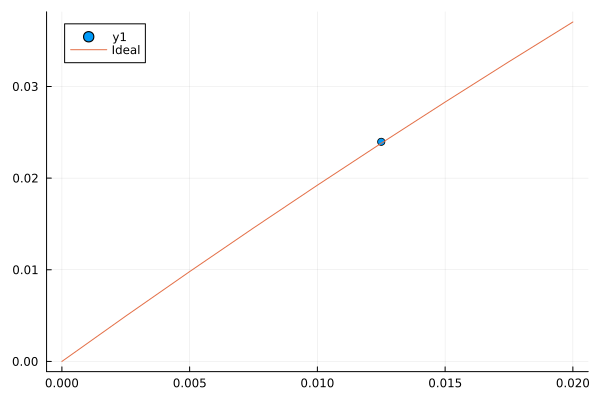

In [123]:
plot([dep,], [real(g_val),], seriestype="scatter")
plot!([0:0.0025:0.02;], [2*i/(1+4*i) for i=0:0.0025:0.02], label="Ideal")

In [37]:
g34_list8 =  [;]
gamma = 1
no_cavs = 8
dt = 0.01
t_final = 10
for dep=0.0025:0.0025:0.02
    println(dep)
    mpo, sites = cash_karppe_evolve(no_cavs, dep, gamma, dt, t_final)
    double, double_sites = n_copy_mpo(2, mpo, sites)
    for i=1:no_cavs
        beamsplitter!(double, i, i+no_cavs, double_sites)
    end
    push!(g34_list8, g_34(double, double_sites, no_cavs))
end

0.0025
0.005
0.0075
0.01
0.0125
0.015
0.0175
0.02


In [95]:
# f = jldopen("g3.jld2", "r")
# g34_list3old = f["g34_list3"]
# close(f)

In [116]:
p = plot([0:0.0025:0.01;], append!([0.0,],real(g34_list10[1:end-1])), label="")
plot!([0:0.0025:0.01;], append!([0.0,],real(g34_list10[1:end-1])),  seriestype="scatter", label="Truncated Simulation")
# plot!([0.0025:0.0025:0.02;], real(g34_list8), label="8 cav")
# plot!([0.0025:0.0025:0.02;], real(g34_list8), seriestype="scatter")
# plot!([0.0025,], real(g34_list3old), seriestype="scatter")
plot!([0:0.0025:0.01;], [2*i/(1+4*i) for i=0:0.0025:0.01], label="Ideal")
plot!(xlabel="Dephasing Error", ylabel="Distinguishability")
Plots.pdf(p, "Distinguishability_plot.pdf")

"Distinguishability_plot.pdf"

In [232]:
prob_test = ODEProblem(dx, 0.1, (0,5))
sol = solve(prob_test, saveat=cumsum(list_t))

retcode: Success
Interpolation: 1st order linear
t: 7-element Vector{Float64}:
 0.0
 0.023787176019345987
 0.0898170419682707
 0.26101793451240834
 0.6789993898990099
 1.6469579859738244
 3.7884277896807528
u: 7-element Vector{Float64}:
 0.1
 0.2398597509195167
 0.43542176370697744
 0.72937901101907
 1.1695988254436376
 1.8176541929302128
 2.7544182327344866

# 
---

# Diff eqn test

In [81]:
no_cavs = 2
sys_sites = siteinds("Qudit", no_cavs+1, dim=3)
input_list = repeat(["Ground",],no_cavs+1)
input_list[1] = "Excite1"
sys = MPO(sys_sites, input_list)

#Generating G2
gamma = 1
t_final = 10
depha = 0

g_f = g2_(gamma, depha, t_final, dt/2, no_cavs)
println("genfunctions")

p = (sys_sites, g_f, sqrt(gamma), depha)
prob = ODEProblem(drho3, sys, (0.0,t_final), p)

genfunctions


┌ Warning: Using arrays or dicts to store parameters of different types can hurt performance.
│ Consider using tuples instead.
└ @ SciMLBase /Users/ygup3491/.julia/packages/SciMLBase/2HZ5m/src/performance_warnings.jl:32


ODEProblem with uType MPO and tType Float64. In-place: false
timespan: (0.0, 10.0)
u0: MPO
[1] ((dim=3|id=501|"Qudit,Site,n=1")', (dim=3|id=501|"Qudit,Site,n=1"), (dim=1|id=742|"Link,l=1"))
[2] ((dim=3|id=289|"Qudit,Site,n=2")', (dim=3|id=289|"Qudit,Site,n=2"), (dim=1|id=131|"Link,l=2"), (dim=1|id=742|"Link,l=1"))
[3] ((dim=3|id=479|"Qudit,Site,n=3")', (dim=3|id=479|"Qudit,Site,n=3"), (dim=1|id=131|"Link,l=2"))


In [82]:
prob2 = ODEProblem(dmpo_test!, sys, (0.0,t_final), p)

ODEProblem with uType MPO and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: MPO
[1] ((dim=3|id=501|"Qudit,Site,n=1")', (dim=3|id=501|"Qudit,Site,n=1"), (dim=1|id=742|"Link,l=1"))
[2] ((dim=3|id=289|"Qudit,Site,n=2")', (dim=3|id=289|"Qudit,Site,n=2"), (dim=1|id=131|"Link,l=2"), (dim=1|id=742|"Link,l=1"))
[3] ((dim=3|id=479|"Qudit,Site,n=3")', (dim=3|id=479|"Qudit,Site,n=3"), (dim=1|id=131|"Link,l=2"))


In [79]:
function dmpo_test!(drho, rho, p, t)
    sites = p[1]
    drho .= 0* MPO(sites, "I")
    
end

dmpo_test! (generic function with 1 method)

In [ ]:
function get_sites(mpo_i)
    no_sites = length(mpo_i)
    site_list = [;]
    for i=1:no_sites-1
        println(uniqueinds(mpo_i[i], mpo_i[i+1]))
        append!( site_list, uniqueinds(mpo_i[i], mpo_i[i+1]))
    end
    noprime!(site_list)
    union!(site_list)
    return site_list
end

In [77]:
function ITensors.oneunit(mpo_i::MPO)
    mpo_sites = siteinds(mpo_i)
    site_list = Index{Int64}[;]
    for i in mpo_sites
        plev(i[1]) == 0 ? push!(site_list, i[1]) : push!(site_list, i[2])
    end
    iden_mpo = MPO(site_list, "I")
    return iden_mpo
end

In [100]:
g34_list10

5-element Vector{Any}:
 0.004456372553084757 + 6.8661973589071875e-12im
 0.009212752913508215 + 3.0330706532980973e-9im
 0.014052481148312554 - 4.686498151937339e-10im
 0.018977736501179093 + 1.453050723863959e-9im
 0.024000385345919372 + 1.8609515342444433e-9im

In [101]:
a = [3,5,6]

3-element Vector{Int64}:
 3
 5
 6

In [104]:
a

3-element Vector{Int64}:
 3
 5
 6

In [103]:
append!([0,], a)

4-element Vector{Int64}:
 0
 3
 5
 6

In [78]:
oneunit(sys)

MPO
[1] ((dim=3|id=64|"Qudit,Site,n=1")', (dim=3|id=64|"Qudit,Site,n=1"), (dim=1|id=96|"Link,l=1"))
[2] ((dim=3|id=355|"Qudit,Site,n=2")', (dim=3|id=355|"Qudit,Site,n=2"), (dim=1|id=133|"Link,l=2"), (dim=1|id=96|"Link,l=1"))
[3] ((dim=3|id=714|"Qudit,Site,n=3")', (dim=3|id=714|"Qudit,Site,n=3"), (dim=1|id=133|"Link,l=2"))


In [ ]:
typeof(sys)

In [85]:
import Base.oneunit

In [94]:
function oneunit(a::Type{Any})
    if typeof(a) == MPO
        return oneunit(a)
    else
        println(a)
        throw("what")
    end
end

oneunit (generic function with 34 methods)

In [96]:
sol = solve(prob2)

Any


String: "what"

# Integ test

In [ ]:
# handling the beginning still issue

In [ ]:
#make a g2 function, outputs the cavity functions

gamma = 1
deph = 0.1
t_fin = 10
dt = 0.01 
no_cavs = 2

# gf1 = g2_(gamma, deph, t_fin, dt, no_cavs; reverse=false)
# gf2 = g2_2(gamma, deph, t_fin, dt, no_cavs; reverse=false)
expect2 = create_MPO(no_cavs, deph, gamma, dt, t_fin)
# gf1

In [ ]:
expect1 = create_MPO(no_cavs, deph, gamma, dt, t_fin)

In [ ]:
plot(expect1[:,1] .- expect2[:,1])
plot!(expect1[:,2] .- expect2[:,2])
plot!(expect1[:,3] .- expect2[:,3])
# plot!(expect1[:,4] .- expect2[:,4])
# plot!(expect1[:,5] .- expect2[:,5])

# plot!(expect2[:,1])

In [ ]:
sum(expect2[end,2:end])

In [ ]:
sum(expect1[end,2:end])

In [ ]:
plot(gf1[2].([0:dt:t_fin;]) .- gf2[2].([0:dt:t_fin;]))
plot!(gf1[2].([0:dt:t_fin;]) )
plot!(gf2[2].([0:dt:t_fin;]))
# plot!(gf1[2].([0:dt:t_fin;]) .- gf2[2].([0:dt:t_fin;]))
# plot!(gf1[3].([0:dt:t_fin;]) .- gf2[3].([0:dt:t_fin;]))
# plot!(gf1[4].([0:dt:t_fin;]) .- gf2[4].([0:dt:t_fin;]))
# plot!(gf1[5].([0:dt:t_fin;]) .- gf2[5].([0:dt:t_fin;]))


In [ ]:
t = [0:0.01:10;]
plot(f.(t))
plot!(sqrt(3)*cum_int.(f,t))
plot!(t.^1.5, seriestype = "scatter")

# Metal GPU speedup

In [ ]:
    #creating initial state and sites
    no_cavs = 2
    sys_sites = siteinds("Qudit", no_cavs+1, dim=3)
    input_list = repeat(["Ground",],no_cavs+1)
    input_list[1] = "Excite1"
    sys = MPO(sys_sites, input_list)
    met_sys = mtl(sys)

In [ ]:
#sparse matrices in julia are in Float64, GPU works on Float32

In [ ]:
mtl(op("I", sys_sites[1]))

In [ ]:
del = ITensor(identity(3), sys_sites[1], sys_sites[1]')

In [ ]:
ITensor([[1,2,3],[3,4,5]]; dtype=Float32)

In [ ]:
swapprime(met_sys[1], 1, 0)

In [ ]:
a = ITensor(met_sys[1])

# checking fidelity reversed 

In [ ]:
fidelity_list =  [;]
self_fidelity_list =  [;]
expect_list = [;]
gamma = 1
no_cavs = 2
dt = 0.02
t_final = 10
depa = 0:0.001:0.1

# for dep in depa
    
#     mpo, sites = create_MPO(no_cavs, dep, gamma, dt, t_final)
#     mpo2, sites2 = create_MPO(no_cavs, dep, gamma, dt, t_final; sites_provided = sites, reverse=true)

#     swapinds!(mpo2[end], sites[end], sites[1])
#     swapinds!(mpo2[end], sites[end]', sites[1]')
#     swapinds!(mpo2[1], sites[2], sites[end])
#     swapinds!(mpo2[1], sites[2]', sites[end]')
#     swapinds!(mpo2[end], sites[1], sites[2])
#     swapinds!(mpo2[end], sites[1]', sites[2]')

#     # swapinds!(mpo2[end-1], sites[end-1], sites[1])
#     # swapinds!(mpo2[end-1], sites[end-1]', sites[1]')
#     # swapinds!(mpo2[2], sites[3], sites[end-1])
#     # swapinds!(mpo2[2], sites[3]', sites[end-1]')
#     # swapinds!(mpo2[end-1], sites[1], sites[3])
#     # swapinds!(mpo2[end-1], sites[1]', sites[3]')


#     row = combiner(sites[2:end], tags="row")
#     ri = combinedind(row)
#     column = combiner(sites[2:end]', tags="column")
#     ci = combinedind(column)

#     ρ = row * prod(mpo) * column
#     ρ = Matrix(ρ, ri, ci)

#     σ = row * prod(mpo2) * column
#     σ = Matrix(σ, ri, ci)
#     σ_2 = σ ^ 0.5

#     push!(fidelity_list, tr(((σ_2) * ρ * (σ_2) ) ^0.5))
#     push!(self_fidelity_list, tr(((σ_2) * σ * (σ_2) ) ^0.5))
#     push!(expect_list, norm(ITensors.expect(mpo, sites[2:end])-ITensors.expect(mpo2, sites[2:end])))
# end
# # mpo, sites = create_MPO(no_cavs, dep, gamma, dt, t_final)
# 0


In [ ]:
var_list = [;]
for dep in depa
    push!(var_list, var(g2_(gamma, dep, t_final, dt, 20; reverse=false)))
end

In [ ]:
# plot(var_list)
plot(g2_(gamma, 1, t_final, dt, 20))

In [ ]:
var(g2_(gamma, 1, t_final, dt, 20))

In [ ]:
gv = g2_(gamma, 0, 10, dt, 4; reverse=false)
0

In [ ]:
plot(gv[1].([0:dt:t_final;]))

In [ ]:
# concern is that swap is not super accurate
# also can look at change in expectation value
# cuurently just exchanging indices

# just unrelated, should prob do many to one as opposed to bus

In [ ]:
#zeroth case sucks

In [ ]:
import Statistics

In [ ]:
var([1,2,0.0])

In [ ]:
p=plot(depa, real(fidelity_list), title="2 Cavs switched ", layout = (2,1), label="fidelity switch", seriestype="scatter")
plot!(depa, real(self_fidelity_list), label="ideal", seriestype="scatter")
plot!(depa, expect_list, subplot=2, label="difference norm", xlabel="Dephasing", seriestype="scatter")
# Plots.pdf(p, "fidelity_check_2cav_fine.pdf")
# xlabel!("Dephasing")
# title!("2 Cav switch")

In [ ]:
dep = 0.0001
no_cavs = 2
dt = 0.01
mpo, sites, expect = create_MPO(no_cavs, dep, gamma, dt, t_final)
mpo2, sites2, expect2 = create_MPO(no_cavs, dep, gamma, dt, t_final; sites_provided = sites, reverse=true)

In [ ]:
expect[end,2] - expect2[end,3]

In [ ]:
plot(expect[:,1])
plot!(expect[:,2])
plot!(expect2[:,3])

# Cavity Beamsplitter

In [ ]:
g34_list6 =  [;]
gamma = 1
no_cavs = 10
dt = 0.02
t_final = 10
for dep=0.0025:0.0025:0.0025
    #println(dep)
    mpo, sites = create_MPO(no_cavs, dep, gamma, dt, t_final)
    #println(ldl_lidt[end])
    # println(ITensors.expect(mpo, sites))
    double, double_sites = n_copy_mpo(2, mpo, sites)
    #println(sum(ITensors.expect(double, double_sites)))
    #normalize!(double)
    for i=1:no_cavs
        beamsplitter!(double, i, i+no_cavs, double_sites)
        #println(tr(double))
    end
    push!(g34_list6, g_34(double, double_sites, no_cavs))
end

In [ ]:
g34_list6 =  [;]
gamma = 1
no_cavs = 5
dt = 0.02
t_final = 10
mpo, sites = create_MPO(no_cavs, 0.005, gamma, dt, t_final)
double, double_sites = n_copy_mpo(2, mpo, sites)
for i=1:no_cavs
    @btime beamsplitter!(double, $i, $i+no_cavs, double_sites)
    #println(tr(double))
end

In [ ]:
g34_list6 =  [;]
gamma = 1
no_cavs = 5
dt = 0.02
t_final = 10
mpo, sites = create_MPO(no_cavs, 0.005, gamma, dt, t_final)
double, double_sites = n_copy_mpo(2, mpo, sites)
for i=1:no_cavs
    @btime beamsplitter_tensor!(double, $i, $i+no_cavs, double_sites)
    #println(tr(double))
end

In [ ]:
jldsave("g3.jld2"; g34_list3)

In [ ]:
f = jldopen("g5.jld2", "r")
g34_list5 = f["g34_list5"]
close(f)
f = jldopen("g5_pt2.jld2", "r")
g34_list5_2 = f["g34_list5"]
close(f)
f = jldopen("g8.jld2", "r")
g34_list8 = f["g34_list8"]
close(f)
f = jldopen("g3.jld2", "r")
g34_list3 = f["g34_list3"]
close(f)

In [ ]:
plot([0:0.0025:0.03;][1:11], [real(g34_list8)]; seriestype="scatter", label="Simulated 8")
plot!([0:0.0025:0.03;][1:11], [real(g34_list8)]; label="")

plot!([0:0.0025:0.03;], [real(g34_list5)]; seriestype="scatter", label="Simulated 5")
plot!([0:0.0025:0.03;], [real(g34_list5)]; label="")

# plot!([0:0.0025:0.0025;], [real(g34_list5_2)]; seriestype="scatter", label="Simulated 5 new")
# plot!([0:0.0025:0.0025;], [real(g34_list5_2)]; label="")

#plot!([0:0.0025:0.02;], [real(g34_list2)], label="")
plot!([0:0.0025:0.03;], [2*i/(1+4*i) for i=0:0.0025:0.03], label="ideal")
xlabel!("Dephasing")
ylabel!("Distinguishability")

In [ ]:
plot([0:0.0025:0.03;][1:11], (ideal_list[1:11]-real(g34_list8)); seriestype="scatter", label="Simulated 8")


plot!([0:0.0025:0.03;], (ideal_list-real(g34_list5)); seriestype="scatter", label="Simulated 5")

ylabel!("Absolute error")

In [ ]:
plot([0:0.0025:0.03;][1:11], (ideal_list[1:11]-real(g34_list8))./ideal_list[1:11]; label="Simulated 8")


plot!([0:0.0025:0.03;], (ideal_list-real(g34_list5))./ideal_list;  label="Simulated 5")

ylabel!("Relative error")

# Checking Bond Dim change with Beamsplitter

- Normalise doesn't reduce bond dimension
-Can use zip up in apply, i think automatically reduces the bond dim vs doing naive and putting truncate true, which still didnt get to min bond d
- Addition doesnt affect bond dim, (automatically reduced)
- naively using apply in the evolution loop wasn't blowing up the bond dim to something absurd (max was around 27 or 21, and mostly stayed around 10) but maybe using zip up will make it better 
- normalise doesnt do much for mpos, avoid


current to do : check negative case see when happ, recreate with atom, compare to analytic
change code to do apply differently, add garbage collection, make sure im making appropriate copies
make an alt gpu code

30/4/24
~ error in atoms evolution is like 10^-10, but the error in the cavitites is way higher , 10^-3 it is 10^-4 for empty cavities, g2 improve doesnt help that much, as compared to time step. 

In [ ]:
later: convergence

In [ ]:
function svdize!(mpo_i, sites_i)
    for i=1:length(sites_i)-1
        mul_term = mpo_i[i] * mpo_i[i+1]
        if i==1
            mpo_i[i], mpo_i[i+1] = qr(mul_term,(sites_i[i],sites_i[i]') )
        else
            mpo_i[i], mpo_i[i+1] = qr(mul_term,(sites_i[i],sites_i[i]',commonind(mpo_i[i-1], mpo_i[i])) )
        end
    end
end

# Dephasing cavities graph

In [ ]:
no_cav_needed_999 = [;]
no_cav_needed_9999 = [;]

for i=0:0.00001:0.02
    dt = 0.01
    gamma = 1
    t_fin = 10
    eigenvals =  g2_(gamma, i, t_fin, dt, 20)
    eigenvals /= sum(eigenvals)
    eigenvals = cumsum(eigenvals)
    push!(no_cav_needed_999, findall(>(0.999), eigenvals)[1])
    push!(no_cav_needed_9999, findall(>(0.9995), eigenvals)[1])
end

In [ ]:
p = plot(0:0.001:2, no_cav_needed_999, linetype=:steppre, label="99.9% Capture", linewidth=3)
plot!(0:0.001:2, no_cav_needed_9999, linetype=:steppre, label="99.95% Capture", linewidth=3)
ylabel!("Cavities")
xlabel!("Dephasing (% of γ)")
plot!(title="Cavities needed to capture Photon Wavefuntion")
Plots.pdf(p, "cav_needed.pdf")

In [ ]:
dt = 0.01
gamma = 1
t_fin = 10
eigenvals =  g2_(gamma, 0, t_fin, dt, 20)

In [ ]:
sum(eigenvals)

In [ ]:
findall(>(6), eigenvals)